# Analysis of quoted language, v2

How is quoted language different form nonquoted language? 

In [4]:
from collections import Counter
import pandas as pd
import numpy as np
%matplotlib inline
from pylab import rcParams
import textacy
rcParams['figure.figsize'] = 10, 4
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [5]:
import spacy
nlp = spacy.load('en')


From the Penn Treebank table: 
https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

27. 	VB 	Verb, base form
28. 	VBD 	Verb, past tense
29. 	VBG 	Verb, gerund or present participle
30. 	VBN 	Verb, past participle
31. 	VBP 	Verb, non-3rd person singular present
32. 	VBZ 	Verb, 3rd person singular present 

In [6]:
tagDict = {"CC": "Coordinating conjunction",
"DT": "Determiner",
"EX": "Existential there",
"IN": "Preposition or subordinating conjunction",
"JJ": "Adjective",
"JJR": "Adjective, comparative",
"JJS": "Adjective, superlative",
"MD": "Modal",
"NN": "Noun, singular or mass",
"NNS": "Noun, plural",
"NNP": "Proper noun, singular",
"NNPS": "Proper noun, plural",
"PDT": "Predeterminer",
"POS": "Possessive ending",
"PRP": "Personal pronoun",
"PRP$": "Possessive pronoun",
"RB": "Adverb",
"RBR": "Adverb, comparative",
"RBS": "Adverb, superlative",
"RP": "Particle",
"TO": "to",
"UH": "Interjection",
"VB": "Verb, base form",
"VBD": "Verb, past tense",
"VBG": "Verb, gerund or present participle",
"VBN": "Verb, past participle",
"VBP": "Verb, non-3rd person singular present",
"VBZ": "Verb, 3rd person singular present",
"WDT": "Wh-determiner",
"WP": "Wh-pronoun",
"WP$": "Possessive wh-pronoun",
"WRB": "Wh-adverb"}

In [7]:
jstorDF = pd.read_json('../txt/e2a.json')
bpoDF = pd.read_json('../txt/e4.json')

In [8]:
mm = open('../middlemarch.txt').read()

In [9]:
mmLength = len(mm)

In [10]:
def tallyQuotes(df, textLength):
    """ Given a DataFrame containing matched Locations in A, 
    i.e. character offsets of quotes, tally these for each character in the text. """
    locs = df['Locations in A'].values
    tally = np.zeros(textLength) # Create a blank tally. 
    for locSet in locs: 
        for loc in locSet: 
            for i in range(loc[0], loc[1]+1): 
                tally[i] += 1
    return tally
    

In [11]:
jstorTally = tallyQuotes(jstorDF, mmLength)
bpoTally = tallyQuotes(bpoDF, mmLength)

In [12]:
jstorTally.max(), bpoTally.max()

(30.0, 30.0)

In [13]:
def getText(tally): 
    """ Gets segements from Middlemarch from the tally. """
    text = ""
    for i in range(len(tally)): 
        if tally[i] - tally[i-1] == 1: # We're on a roll
            text += (mm[tally[i]])
        else: 
            text += (' ' + mm[tally[i]]) # Put spaces between quotes
    return text

In [14]:
def segment(tally, cutoff=4): 
    """ Divides a tally into three parts: nonquotes,  
    moderaly quoted passages, and highly quoted passages. 
    Returns a list of three SpaCy docs. """
    nonQuotedIndices = np.where(tally == 0)[0]
    quotedIndices = np.where((tally > 0) & (jstorTally < cutoff))[0]
    highlyQuotedIndices = np.where(tally >= cutoff)[0]
    texts = [getText(text) for text in [nonQuotedIndices, quotedIndices, highlyQuotedIndices]]
    docs = [nlp(text) for text in texts]
    return docs
    

In [15]:
def POSSignature(doc): 
    """ Gets the POS proportions for a document. """
    tags = [w.tag_ for w in doc]
    count = pd.Series(Counter(tags))/len(doc)
    return count

In [16]:
jstorDocs = segment(jstorTally)
bpoDocs = segment(bpoTally)

In [17]:
# Wordcounts for nonquotes, moderately quoted passages, and highly quoted passages
# for JSTOR and BPO docs. 
[len(group) for group in jstorDocs], [len(group) for group in bpoDocs]

([352071, 54828, 6671], [345468, 61838, 7842])

In [18]:
jstorPOS = [POSSignature(doc) for doc in jstorDocs]
bpoPOS = [POSSignature(doc) for doc in bpoDocs]

In [19]:
labels = ['JSTOR-Nonquotes', 'JSTOR-Quotes', 'JSTOR-FreqQuotes', 'BPO-Nonquotes', 'BPO-Quotes', 'BPO-FreqQuotes']
posDF = pd.DataFrame(jstorPOS + bpoPOS, 
             index=labels).fillna(0)

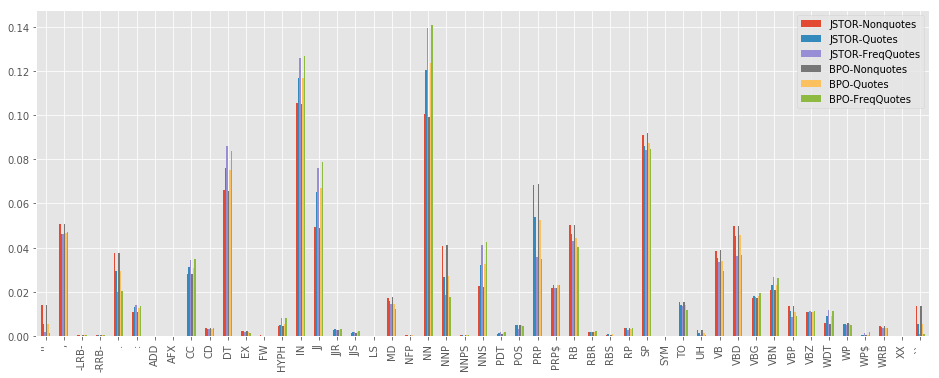

In [20]:
posDF.T.plot(kind='bar', figsize=(16,6))

In [21]:
tagList = ['IN', 'JJ', 'JJR', 'JJS', 'NN', 'NNPS', 'NNS', 'POS', 'PRP', 'WP$']

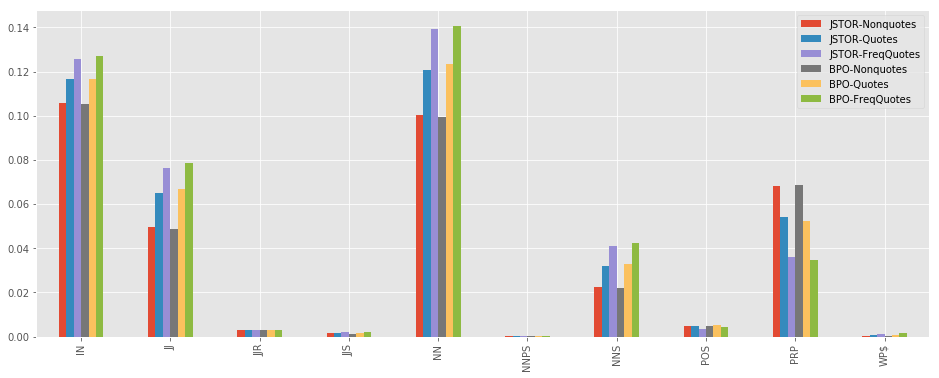

In [22]:
posDF[tagList].T.plot(kind='bar', figsize=(16,6))

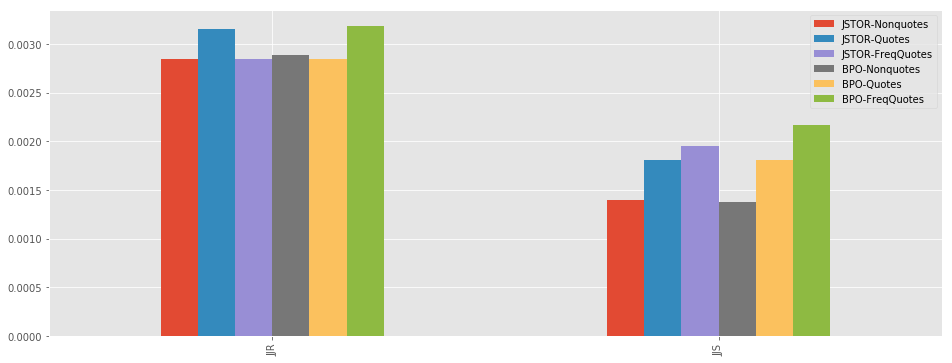

In [23]:
posDF[['JJR', 'JJS']].T.plot(kind='bar', figsize=(16,6))

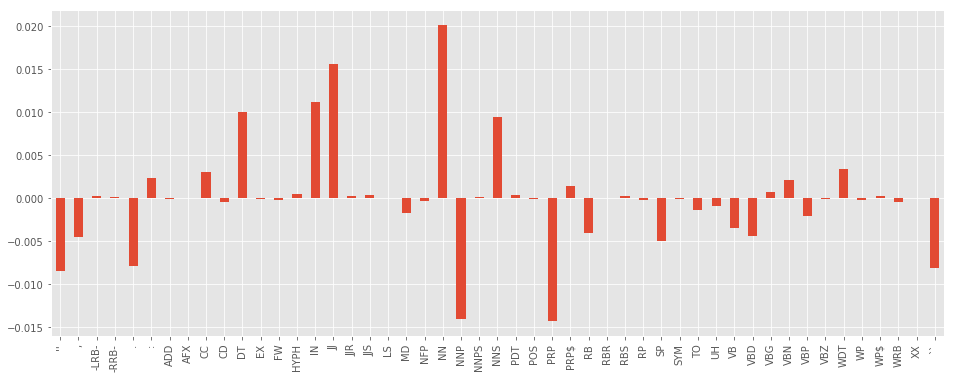

In [24]:
(posDF.loc['JSTOR-Quotes'] - posDF.loc['JSTOR-Nonquotes']).plot(kind='bar', figsize=(16,6))

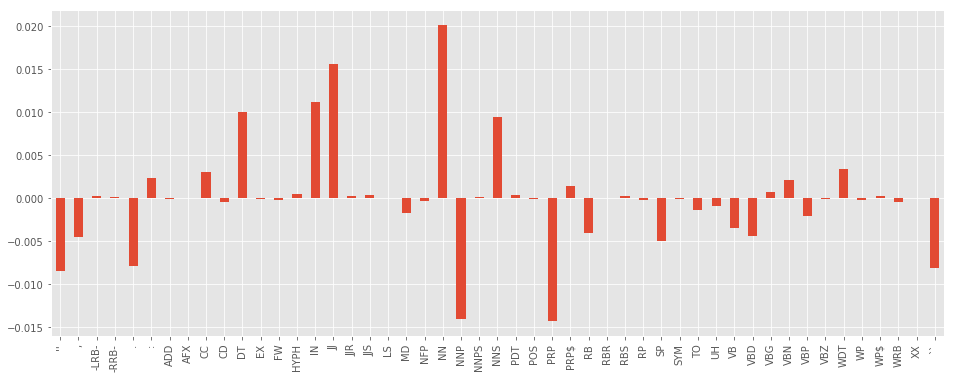

In [28]:
ax = (posDF.loc['JSTOR-Quotes'] - posDF.loc['JSTOR-Nonquotes']).plot(kind='bar', figsize=(16,6))
fig = ax.get_figure()
fig.savefig('pos-tags.png', bboxinches='tight', dpi=300)

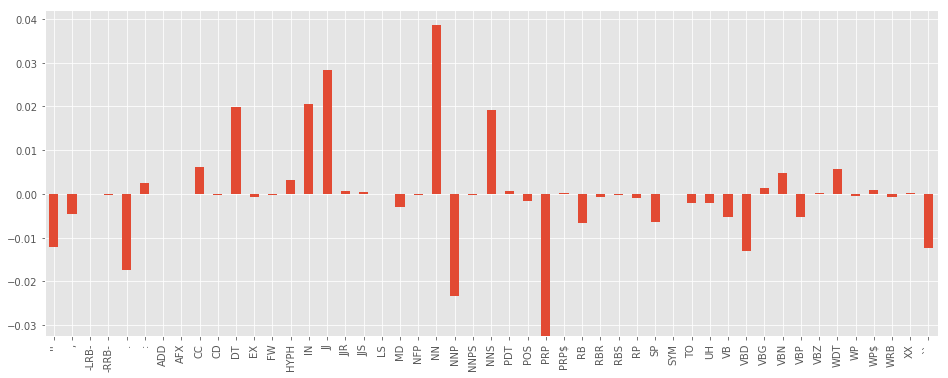

In [138]:
(posDF.loc['JSTOR-FreqQuotes'] - posDF.loc['JSTOR-Nonquotes']).plot(kind='bar', figsize=(16,6))

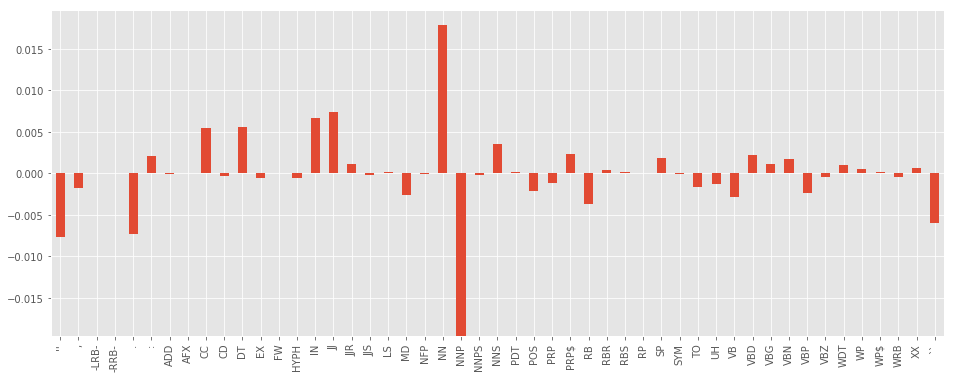

In [139]:
(posDF.loc['BPO-Quotes'] - posDF.loc['BPO-Nonquotes']).plot(kind='bar', figsize=(16,6))

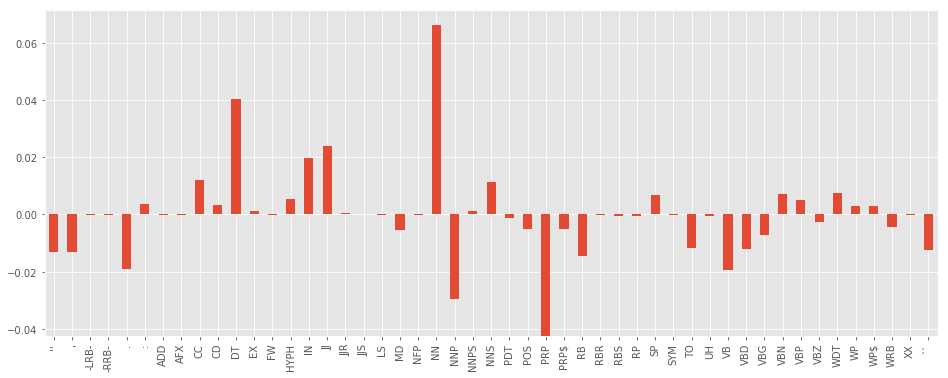

In [140]:
(posDF.loc['BPO-FreqQuotes'] - posDF.loc['BPO-Nonquotes']).plot(kind='bar', figsize=(16,6))

# MDWs

In [168]:
allDocs = jstorDocs + bpoDocs

In [182]:
def bagOfTerms(text): 
    doc = textacy.Doc(text)
    bag = doc.to_bag_of_terms(as_strings=True, lemmatize=True, weighting='freq')
    return pd.Series(bag)

In [184]:
docTerms = [bagOfTerms(doc) for doc in allDocs]

In [188]:
df = pd.DataFrame(docTerms, index=labels).fillna(0)

In [193]:
(df.loc['JSTOR-Quotes'] - df.loc['JSTOR-Nonquotes']).sort_values()

say             -0.003610
mr.             -0.002072
fred            -0.001886
bulstrode       -0.001726
lydgate         -0.001587
mary            -0.001194
garth           -0.001148
celia           -0.000989
james           -0.000984
not             -0.000958
mrs.            -0.000949
farebrother     -0.000755
vincy           -0.000669
rosamond        -0.000663
brooke          -0.000621
'               -0.000612
sir             -0.000537
raffles         -0.000531
wish            -0.000521
go              -0.000509
tell            -0.000486
ladislaw        -0.000475
come            -0.000475
shall           -0.000454
caleb           -0.000453
hear            -0.000418
sir james       -0.000413
middlemarch     -0.000409
lowick          -0.000394
speak           -0.000392
                   ...   
fall             0.000259
face             0.000260
paris            0.000260
struggle         0.000263
lie              0.000264
desire           0.000265
english          0.000267
touch       

In [194]:
(df.loc['JSTOR-FreqQuotes'] - df.loc['JSTOR-Nonquotes']).sort_values()

say             -0.006397
lydgate         -0.004499
mr.             -0.003395
bulstrode       -0.002948
fred            -0.002781
rosamond        -0.002616
mary            -0.001792
not             -0.001615
know            -0.001411
's              -0.001404
mrs.            -0.001375
james           -0.001368
garth           -0.001308
go              -0.001281
farebrother     -0.001211
good            -0.001175
middlemarch     -0.001157
come            -0.001084
'               -0.000995
sir             -0.000938
vincy           -0.000880
ladislaw        -0.000831
tell            -0.000820
speak           -0.000749
shall           -0.000706
mean            -0.000706
think           -0.000696
caleb           -0.000686
dorothea        -0.000682
say mr.         -0.000679
                   ...   
human            0.000663
emotion          0.000666
thought          0.000673
rome             0.000679
struggle         0.000685
ardent           0.000700
marriage         0.000704
small       

In [195]:
(df.loc['BPO-Quotes'] - df.loc['BPO-Nonquotes']).sort_values()

mr.             -0.003859
's              -0.002553
fred            -0.002487
say             -0.002419
casaubon        -0.002100
mrs.            -0.001329
garth           -0.001287
james           -0.001282
not             -0.001220
brooke          -0.001156
farebrother     -0.001091
bulstrode       -0.001026
vincy           -0.001010
lydgate         -0.001003
dorothea        -0.000960
ladislaw        -0.000921
caleb           -0.000802
mary            -0.000735
rosamond        -0.000662
cadwallader     -0.000645
lowick          -0.000640
mr. casaubon    -0.000631
think           -0.000625
wish            -0.000616
sir james       -0.000538
come            -0.000513
thing           -0.000506
mr. brooke      -0.000497
say mr.         -0.000492
father          -0.000485
                   ...   
d                0.000333
wake             0.000333
nature           0.000333
labor            0.000338
year             0.000339
wilberforce      0.000343
death            0.000346
hard        

In [196]:
(df.loc['BPO-FreqQuotes'] - df.loc['BPO-Nonquotes']).sort_values()

say                      -0.006101
mr.                      -0.004911
's                       -0.004774
lydgate                  -0.004568
dorothea                 -0.004117
casaubon                 -0.003035
bulstrode                -0.002721
know                     -0.002612
fred                     -0.002604
rosamond                 -0.002533
good                     -0.002381
think                    -0.002320
come                     -0.002091
like                     -0.001924
brooke                   -0.001916
look                     -0.001832
mary                     -0.001787
mrs.                     -0.001739
go                       -0.001650
little                   -0.001528
not                      -0.001513
garth                    -0.001345
thing                    -0.001325
celia                    -0.001302
james                    -0.001282
tell                     -0.001203
farebrother              -0.001150
vincy                    -0.001127
middlemarch         